In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from model.resnet import ResNet18
from model.resnext import CifarResNeXt
from model.wrn import WideResNet
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
resnet18 = ResNet18() # student model
# resnext = CifarResNeXt(cardinality=8, depth=29, num_classes=10)
wrn = WideResNet(depth=28, num_classes=10, widen_factor=10, dropRate=0.3)

resnet18.load_state_dict(torch.load('./experiments/resnet18_distill/resnext_teacher/best.pth.tar', map_location='cpu')['state_dict'])


state_dict = torch.load('./experiments/base_wrn/best.pth.tar', map_location='cpu')['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
wrn.load_state_dict(new_state_dict, )

# resnext.load_state_dict(torch.load('./experiments/base_resnext29/best.pth.tar', map_location='cpu')['state_dict'])

<All keys matched successfully>

In [3]:
train_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='./data-cifar10', train=True, download=True, transform=train_transformer)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)

Files already downloaded and verified


In [4]:
images = []
labels = []

for i, (train_batch, labels_batch) in enumerate(trainloader):

    if i == 1:
        break
    print(train_batch.shape, labels_batch)

    images.append(train_batch)
    labels.append(labels_batch)

torch.Size([5, 3, 32, 32]) tensor([0, 8, 1, 3, 7])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


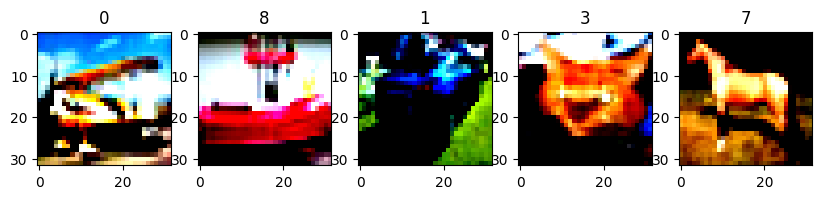

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(images[0][i].numpy().transpose(1, 2, 0))
    ax[i].set_title(labels[0][i].item())

In [6]:
for name, param in wrn.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([16, 3, 3, 3])
block1.layer.0.bn1.weight torch.Size([16])
block1.layer.0.bn1.bias torch.Size([16])
block1.layer.0.conv1.weight torch.Size([160, 16, 3, 3])
block1.layer.0.bn2.weight torch.Size([160])
block1.layer.0.bn2.bias torch.Size([160])
block1.layer.0.conv2.weight torch.Size([160, 160, 3, 3])
block1.layer.0.convShortcut.weight torch.Size([160, 16, 1, 1])
block1.layer.1.bn1.weight torch.Size([160])
block1.layer.1.bn1.bias torch.Size([160])
block1.layer.1.conv1.weight torch.Size([160, 160, 3, 3])
block1.layer.1.bn2.weight torch.Size([160])
block1.layer.1.bn2.bias torch.Size([160])
block1.layer.1.conv2.weight torch.Size([160, 160, 3, 3])
block1.layer.2.bn1.weight torch.Size([160])
block1.layer.2.bn1.bias torch.Size([160])
block1.layer.2.conv1.weight torch.Size([160, 160, 3, 3])
block1.layer.2.bn2.weight torch.Size([160])
block1.layer.2.bn2.bias torch.Size([160])
block1.layer.2.conv2.weight torch.Size([160, 160, 3, 3])
block1.layer.3.bn1.weight torch.Size([160])

In [7]:
# import torchvision.models as models
# model = models.resnet50(pretrained=True)
# # print(model.layer4)

# for name, param in model.named_parameters():
#     print(name, param.shape)

In [8]:
# these are the weights we will use for class activation mapping
fc_params = torch.tensor([])
for name, param in resnet18.named_parameters():
    # print(name, param.shape)
    if name == 'linear.weight':
        fc_params = param
        print(name, param.shape)


# these are the weights we will use for class activation mapping
fc_params_teacher = torch.tensor([])
for name, param in wrn.named_parameters():
    # print(name, param.shape)
    if name == 'fc.weight':
        fc_params_teacher = param
        print(name, param.shape)

linear.weight torch.Size([10, 512])
fc.weight torch.Size([10, 640])


In [9]:
print(wrn.relu)

ReLU(inplace=True)


In [10]:
# register forward hook to get the 7 X 7 X 2048 output before the average pooling layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# adding forward hook to the penultimate relu layer
resnet18.layer4[1].shortcut.register_forward_hook(get_activation('shortcut'))
wrn.relu.register_forward_hook(get_activation('relu'))
# resnet18.layer4[2].relu.register_forward_hook(get_activation('relu'))

In [11]:
def get_weighted_CAM(forward_hooked_model, index, weights, student = True, rescale=True):
    # print(weights.shape)

    if student:
        key = 'shortcut'
        layer_size = 512
        resize_val = 4
    else:
        key = 'relu'
        layer_size = 640
        resize_val = 8
    _ = forward_hooked_model(torch.unsqueeze(images[0][index], 0))
    activation[key] = activation[key][0]
    activation[key] = activation[key].permute(1, 2, 0)
    # 7 X 7 X 2048 => 49 X 512
    activation[key] = activation[key].reshape(-1, layer_size)

    # class_index = actual_labels_indices[index]
    # weighted sum of the 2048 class activation maps
    activation_map = torch.matmul(activation[key], weights) # 49 X 1
    activation_map = activation_map.reshape(resize_val, resize_val)
    
    if rescale:
        # activation_map = torch.nn.functional.relu(activation_map)
        activation_map = activation_map - torch.min(activation_map)
        activation_map = activation_map / (torch.max(activation_map) - torch.min(activation_map))
        activation_map = activation_map * 255

    return activation_map

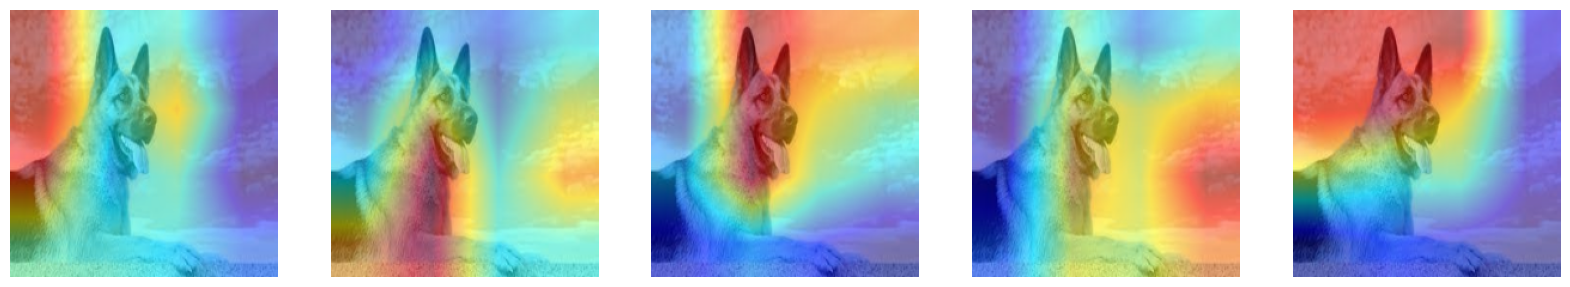

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i in range(5):  
    activation_map = get_weighted_CAM(resnet18, i, fc_params[labels[0][i]])

    activation_map = activation_map.detach().numpy().astype(np.uint8)

    activation_map = cv2.resize(activation_map, (224, 224))
    activation_map = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)
    original_image = cv2.imread('/Users/aayush/Desktop/AAYUSH/COLLEGE/SEMESTERS/SEMESTER 6/AI5100/Assignments/Assignment 3/images/i1.jpg')
    original_image = cv2.resize(original_image, (224, 224))
    activation_map = cv2.addWeighted(original_image, 0.5, activation_map, 0.5, 0)

    axes[i].imshow(activation_map)
    axes[i].axis('off')

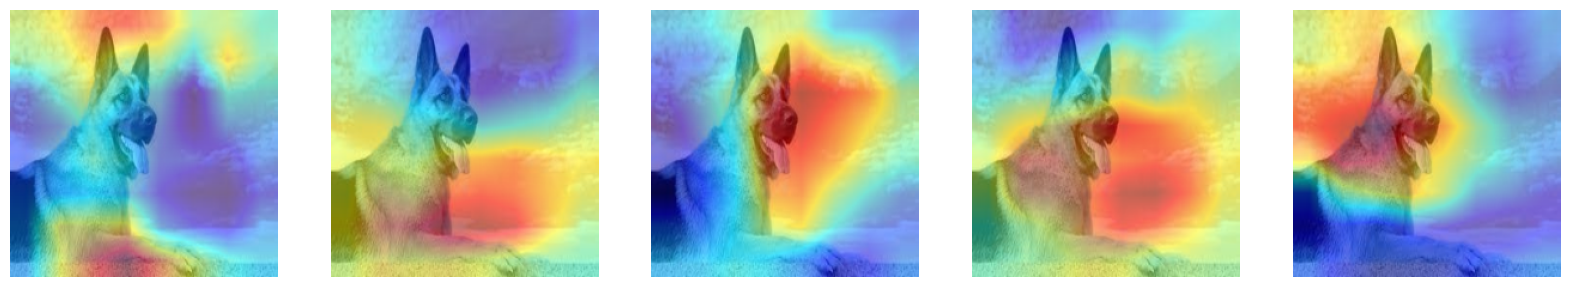

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i in range(5):  
    activation_map = get_weighted_CAM(wrn, i, fc_params_teacher[labels[0][i]], student=False)

    activation_map = activation_map.detach().numpy().astype(np.uint8)

    activation_map = cv2.resize(activation_map, (224, 224))
    activation_map = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)
    original_image = cv2.imread('/Users/aayush/Desktop/AAYUSH/COLLEGE/SEMESTERS/SEMESTER 6/AI5100/Assignments/Assignment 3/images/i1.jpg')
    original_image = cv2.resize(original_image, (224, 224))
    activation_map = cv2.addWeighted(original_image, 0.5, activation_map, 0.5, 0)

    axes[i].imshow(activation_map)
    axes[i].axis('off')